# Preparing COSMOS shape catalog

In this notebook, we prepare the full (with both bright and faint galaxies) COSMOS shape catalog using 
weak lensing measurements from [Schrabback et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...516A..63S/abstract).

Most important catalog's columns described in Tim's README:
-   1 Ra                  
-   2 Dec                 
-   3 Xs                  Mosaic X-Y coordinates (North up, East left)
-   4 Ys                  with pixel scale 0.186''. Can directly be used with      e1iso_snCal_rot4  e2iso_snCal_rot4            
-   5 MAG_AUTO            Kron-like elliptical aperture magnitude         [mag]   
-   6 e1iso_rot4_gr_snCal BEST gamma1-estimate for North=up  all fixes included   
-   7 e2iso_rot4_gr_snCal BEST gamma2-estimate for North=up  all fixes included
-  12 nhweight_int        shear-measurement weight (similar to Hoekstra et al.)
-  21 zphot               best-fit photoz estimate
-  37 z_problem           Potentially high redshift (zphot<0.6, MAG_AUTO>24)                                              0=fine, 1=bad (i>24), 2=verybad (i>24, zphot_sec>0)                    
For a proper redshift calibration you probably want to select z_problem=0
or z_problem<=1 (in the latter case you only exclude those galaxies
with a sig. secondary redshift peak, which is probably sufficient).

## Load lensing data

**Loading catalog with bright galaxies**

In [1]:
%pylab inline
from astropy.table import Table
from astropy.io import fits

cat_bright = Table.read('../data/COSMOS/cosmos_bright_cat.asc', format='ascii')

Populating the interactive namespace from numpy and matplotlib


**Loading catalog with faint galaxies**

In [2]:
cat_faint = Table.read('../data/COSMOS/z_cos30/cosmos_faint_cat.asc', format='ascii')

Redshift distrubtion of faint galaxies

Text(0.5,1,'bright galaxies redshift distribution')

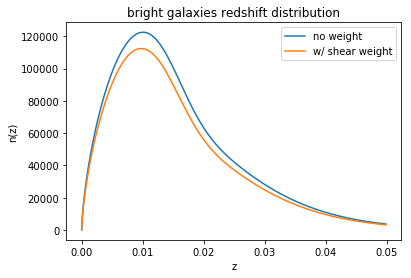

In [3]:
nz_w0 = Table.read('../data/COSMOS/z_cos30/cosmos_zdist_faint_w0.asc', format='ascii')
nz_w1 = Table.read('../data/COSMOS/z_cos30/cosmos_zdist_faint_w1.asc', format='ascii')

plot(nz_w0['col1']/100, nz_w0['col2'], label='no weight')
plot(nz_w1['col1']/100, nz_w1['col2'], label='w/ shear weight')
xlabel('z')
ylabel('n(z)')
legend()
title('bright galaxies redshift distribution')

In [4]:
# These show the borders of the cosmos field
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

from lenspack.geometry.projections import gnom
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

## Apply necessary quality cuts

Discarding galaxies with redshift measurment problem

In [5]:
# We actually keep everything, only potentially high z galaxies
selection = ((cat_bright['z_problem'] == 0)
            )
# Restrict catalog to these objects
cat_bright = cat_bright[selection]

In [6]:
print(cat_bright.keys())

['Ra', 'Dec', 'Xs', 'Ys', 'MAG_AUTO', 'e1iso_rot4_gr_snCal', 'e2iso_rot4_gr_snCal', 'e1iso_rot1_gr_snCal', 'e2iso_rot1_gr_snCal', 'e1iso_snCal_rot4', 'e2iso_snCal_rot4', 'nhweight_int', 'rh', 'rg', 'next_dist', 'region', 'snratio', 'e1corr_rot', 'e2corr_rot', 'mod_gal', 'zphot', 'zerr_68_min', 'zerr_68_max', 'zerr_99_min', 'zerr_99_max', 'imag', 'chi_gal', 'zphot_sec', 'chi_sec', 'mod_sec', 'Mv', 'jmag', 'jmagerr', 'kmag', 'kmagerr', 'z_problem', 'LRG']


In [7]:
# Creat the full catalog
type(cat_bright)

astropy.table.table.Table

Text(0.5,0,'faint galaxies')

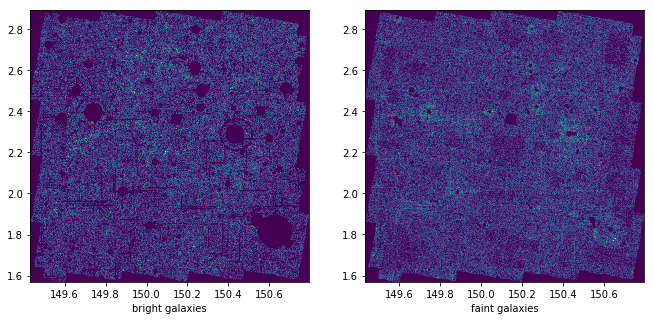

In [8]:
figure(figsize=(11, 5))
subplot(121)
xlabel("bright galaxies")
hist2d(cat_bright['Ra'], cat_bright['Dec'], 320)
subplot(122)
hist2d(cat_faint['Ra'], cat_faint['Dec'], 320)
xlabel("faint galaxies")

In [9]:
# merge catalog
cat_full = Table()
cat_full['Ra'] = np.concatenate([cat_bright['Ra'], cat_faint['Ra']])
cat_full['Dec'] = np.concatenate([cat_bright['Dec'], cat_faint['Dec']])
cat_full['e1iso_rot4_gr_snCal'] = np.concatenate([cat_bright['e1iso_rot4_gr_snCal'], cat_faint['e1iso_rot4_gr_snCal']])
cat_full['e2iso_rot4_gr_snCal'] = np.concatenate([cat_bright['e2iso_rot4_gr_snCal'], cat_faint['e2iso_rot4_gr_snCal']])
cat_full['nhweight_int'] = np.concatenate([cat_bright['nhweight_int'], cat_faint['nhweight_int']])

In [10]:
cat_full

Ra,Dec,e1iso_rot4_gr_snCal,e2iso_rot4_gr_snCal,nhweight_int
float64,float64,float64,float64,float64
149.4959651,2.499495782,0.0392358,-0.574703,1.2926
149.4963267,2.504209582,-0.515389,-0.374299,1.12024
149.4928198,2.487398982,-0.185595,0.327772,1.72788
149.4862006,2.455142982,0.113546,0.00384063,0.429384
149.4883566,2.467923482,-0.170634,0.216532,0.770267
149.4872945,2.462888682,-0.142334,-0.149079,1.05549
149.4936394,2.499830082,0.561479,0.110478,1.46717
149.4877778,2.466954182,0.0983129,-0.30416,0.561906
149.4855088,2.460576982,0.00236967,0.0267271,1.35167


## Bin ellipticity catalog on map with given pixel size

| Simulation    | Resolution (arcmin/pixel)  |
|:------------- |:--------------------------:|
| [MassiveNuS](http://columbialensing.org/#massivenus)    | 0.4                        |
| [kappaTNG](http://columbialensing.org/#tng)             | 0.29                       |

In [11]:
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93, ks93inv
from lenspack.peaks import find_peaks2d

# Compute boundaries of the field so that it fits in a 512x512 map
# with pixel resolution of 0.29 arcmin
resolution = 0.29
width = 360
size = width * resolution / 60.

ra = median(cat_full['Ra'])
dec = median(cat_full['Dec'])
extent = [ra - size/2, ra + size/2, dec - size/2, dec + size/2]

In [12]:
# Bin ellipticity components based on galaxy position into a 320x320 map
e1map, e2map = bin2d(cat_full['Ra'], cat_full['Dec'], 
                     v=(cat_full['e1iso_rot4_gr_snCal'], cat_full['e2iso_rot4_gr_snCal']), 
                     w=cat_full['nhweight_int'],
                     npix=width,
                     extent=extent)

Text(0.5,1,'e2')

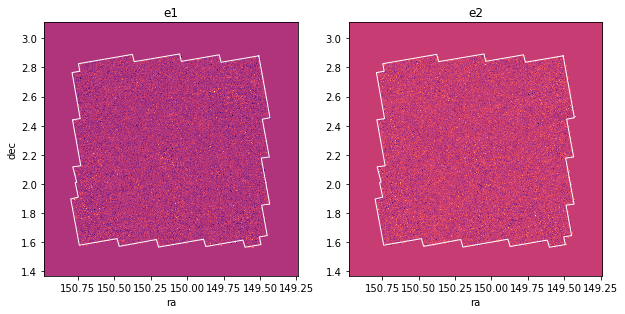

In [13]:
figure(figsize=[10,5])
subplot(121)
imshow(e1map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
title('e1')

subplot(122)
imshow(e2map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
title('e2')

In [14]:
e2map.shape
#fits.writeto('../data/COSMOS/cosmos_full_e1_0.29arcmin{}.fits'.format(width), e1map.astype('float32'))
#fits.writeto('../data/COSMOS/cosmos_full_e2_0.29arcmin{}.fits'.format(width), -e2map.astype('float32'))

(360, 360)

## Create map of number of galaxies per pixel

Text(0.5,1,'faint catalog')

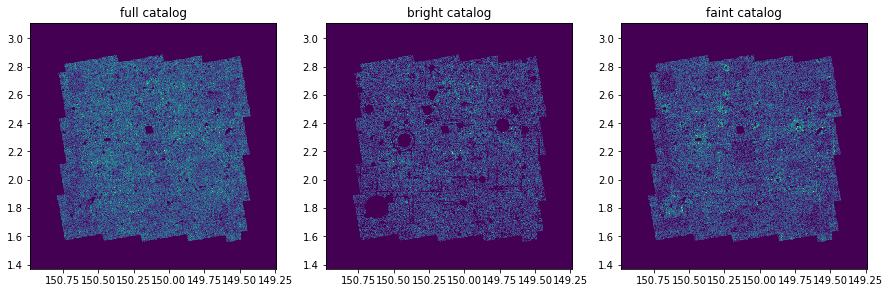

In [15]:
n_gal_map_full = bin2d(cat_full['Ra'], cat_full['Dec'], 
                     npix=width,
                     extent=extent)

#fits.writeto('../data/COSMOS/cosmos_full_ngal_0.29arcmin{}.fits'.format(width), n_gal_map_full.astype('float32'))

n_gal_map_bright = bin2d(cat_bright['Ra'], cat_bright['Dec'], 
                     npix=width,
                     extent=extent)

n_gal_map_faint = bin2d(cat_faint['Ra'], cat_faint['Dec'], 
                     npix=width,
                     extent=extent)

figure(figsize=[15,5])
subplot(131)
imshow(n_gal_map_full, origin='lower', extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
title('full catalog')

subplot(132)
imshow(n_gal_map_bright, origin='lower', extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
title('bright catalog')

subplot(133)
imshow(n_gal_map_faint, origin='lower', extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
title('faint catalog')

## Creat binary mask for empty pixels

Text(0.5,1,'binary mask')

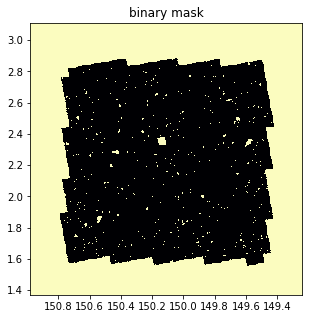

In [16]:
# Data mask
figure(figsize=[5,5])
m = n_gal_map_full == 0
imshow(m, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width))
xlim(gca().get_xlim()[::-1])
title("binary mask")

#fits.writeto('../data/COSMOS/cosmos_full_mask_0.29arcmin{}.fits'.format(width), (1.-m).astype('float32'))

In [17]:
(1.-m).astype('float32').shape

(360, 360)

##  Recover convergence via Kaiser-Squires inversion

In [18]:
kappaE, kappaB = ks93(e1map, -e2map) # I think e2 is inverted...

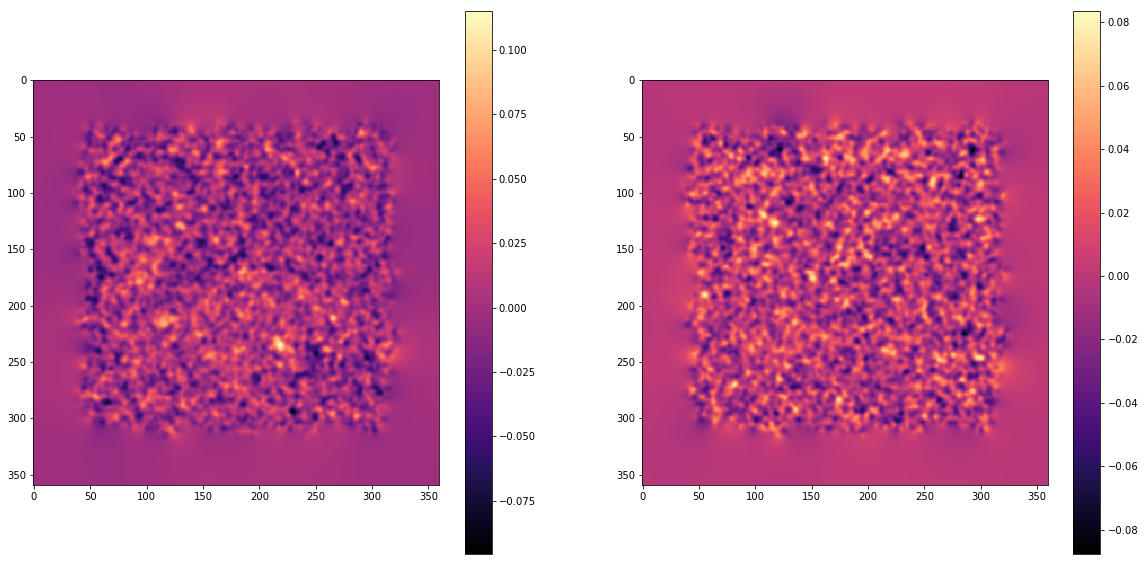

In [19]:
from scipy.ndimage import gaussian_filter
figure(figsize=[20,10])
subplot(121)
mappable = imshow(gaussian_filter(kappaE,2)[:,::-1], cmap='magma');colorbar()
subplot(122)
mappable = imshow(gaussian_filter(kappaB,2)[:,::-1], cmap='magma');colorbar()

# Redshift distrubution of the full catalog

Be careful that the faint catalog has a x100 factor in its redshift distribution.

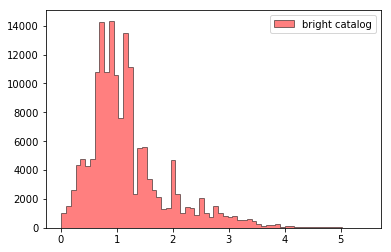

In [20]:
hist(cat_bright['zphot'], bins=64, color="red", alpha=0.5, ec="k", histtype='stepfilled',
     label='bright catalog');
legend()

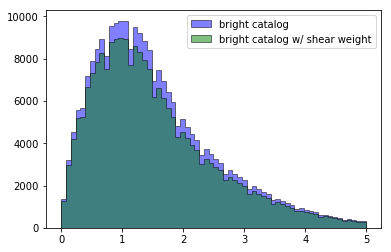

In [21]:
hist(nz_w0['col1'], weights=nz_w0['col2']/100, bins=64, color="blue", alpha=0.5, ec="k", histtype='stepfilled',
     label='bright catalog');

hist(nz_w1['col1'], weights=nz_w1['col2']/100, bins=64, color="green", alpha=0.5, ec="k", histtype='stepfilled',
     label='bright catalog w/ shear weight');
legend()

In [22]:
np.max(cat_bright['zphot'])

5.446

In [23]:
z = np.arange(0, 5.5, .01)

nz_bright = np.zeros(z.shape)
for z_gal in cat_bright['zphot']:
    nz_bright[int(np.ceil(z_gal*100))] += 1
    
nz_faint = np.zeros(z.shape)
nz_faint[0:500] = nz_w0['col2']/100

nz_faint_w = np.zeros(z.shape)
nz_faint_w[0:500] = nz_w1['col2']/100

nz_full = nz_faint + nz_bright
nz_full_w = nz_faint_w + nz_bright

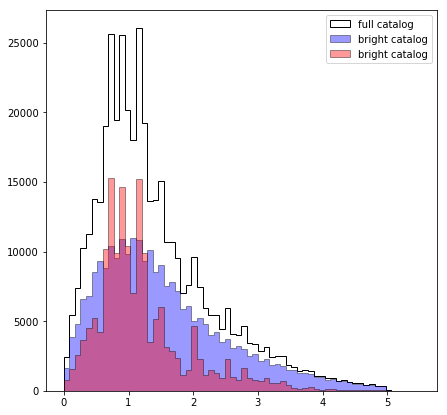

In [24]:
figure(figsize=(7,7))
hist(z, weights=nz_full, bins=64, color="white", alpha=1, ec="k", histtype='stepfilled',
     label='full catalog');
hist(z, weights=nz_faint, bins=64, color="blue", alpha=.4, ec="k", histtype='stepfilled',
     label='bright catalog');
hist(z, weights=nz_bright, bins=64, color="red", alpha=.4, ec="k", histtype='stepfilled',
     label='bright catalog');
legend()

Let's export 3 files:

- `hist_z.npy`: the x axis of the full redshift histogram plotted above
- `hist_n_z.npy`: the corresponding y axis (n_z)
- `redshift_catalog.npy`: all the redshift values in the full catalog

In [25]:
#np.save("hist_z.npy", z)
#np.save("hist_n_z.npy", nz_full)

redshift_catalog = np.array([i/100 for (i,z) in enumerate(nz_full) for _ in range(int(np.round(z)))])
#np.save("redshift_catalog.npy", redshift_catalog)

Text(0,0.5,'nhweight_int')

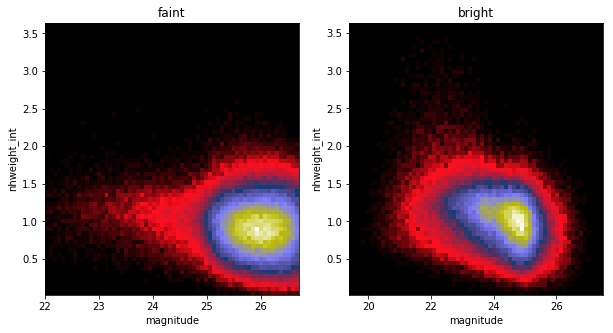

In [26]:
figure(figsize=(10, 5))

subplot(121)
title('faint')
hist2d(cat_faint['MAG_AUTO'], cat_faint['nhweight_int'], 64, cmap='gist_stern');
xlabel('magnitude')
ylabel('nhweight_int')

subplot(122)
title('bright')
hist2d(cat_bright['MAG_AUTO'], cat_bright['nhweight_int'], 64, cmap='gist_stern');
xlabel('magnitude')
ylabel('nhweight_int')

## Simulation with COSMOS noise realisation

Apply a random rotation to COSMOS ellpticities

In [27]:
from lenspack.shear import random_rotation

In [50]:
e1_cosmos = cat_full['e1iso_rot4_gr_snCal']
e2_cosmos = cat_full['e2iso_rot4_gr_snCal']

In [51]:
e1map, e2map = bin2d(cat_full['Ra'], cat_full['Dec'], 
                     v=(e1_cosmos, -e2_cosmos), 
                     w=cat_full['nhweight_int'],
                     npix=width,
                     extent=extent)

In [52]:
kwargs=dict(vmin=-.05, vmax=.1, cmap='magma')

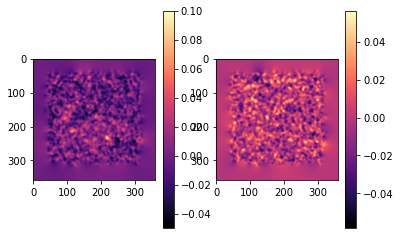

In [53]:
kappaE, kappaB = ks93(e1map, e2map) # I think e2 is inverted...
subplot(121)
imshow(gaussian_filter(kappaE,3)[:,::-1], **kwargs);colorbar()
subplot(122)
imshow(gaussian_filter(kappaB,3)[:,::-1], cmap='magma');colorbar()

In [54]:
e1_random, e2_random = random_rotation(e1_cosmos, e2_cosmos)

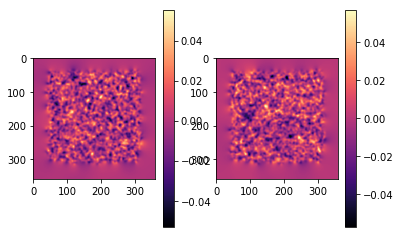

In [56]:
e1map_noise, e2map_noise = bin2d(cat_full['Ra'], cat_full['Dec'], 
                     v=(e1_random, -e2_random), 
                     w=cat_full['nhweight_int'],
                     npix=width,
                     extent=extent)
kappaE, kappaB = ks93(e1map_noise, e2map_noise) # I think e2 is inverted...
subplot(121)
imshow(gaussian_filter(kappaE,3)[:,::-1], cmap='magma');colorbar()
subplot(122)
imshow(gaussian_filter(kappaB,3)[:,::-1], cmap='magma');colorbar()

Add e1 and e2 from noiseless simulations

0.10825301633653538
0.1078539122987307


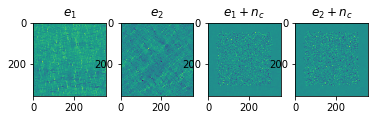

In [34]:
kp = np.load('../data/ktng/ktng_kappa360v2.npy')
e1_sim, e2_sim = ks93inv(kp, np.zeros_like(kp))
subplot(141)
imshow(e1_sim)
title(r'$e_1$')
subplot(142)
imshow(e2_sim)
title(r'$e_2$')
subplot(143)
imshow(e1_sim + e1map_noise)
print(np.std(e1map_noise))
title(r'$e_1 + n_c$')
subplot(144)
imshow(e2_sim + e2map_noise)
print(np.std(e2map_noise))
title(r'$e_2 + n_c$')

np.save('../data/ktng/cosmos_noise/e1.npy', e1_sim + e1map_noise)
np.save('../data/ktng/cosmos_noise/e2.npy', e2_sim + e2map_noise)

Look at KS reconstruction

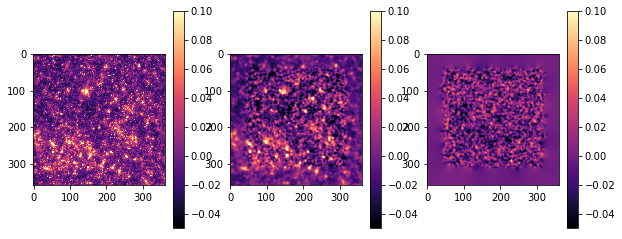

In [35]:
kappaE, kappaB = ks93(e1_sim+e1map_noise, e2_sim+e2map_noise)


figure(figsize=[10,4])

subplot(131)
imshow(kp[:,::-1], **kwargs);colorbar()
subplot(132)
imshow(gaussian_filter(kappaE,2)[:,::-1], **kwargs);colorbar()
subplot(133)
imshow(gaussian_filter(kappaB,2)[:,::-1], **kwargs);colorbar()

## Simulation with noise taking into account n_gal

In [36]:
mask = 1-m
denominator = n_gal_map_full.copy()
denominator = 1./np.sqrt(n_gal_map_full)

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
denominator *= mask
denominator = np.nan_to_num(denominator)

cov1 = np.std(cat_full['e1iso_rot4_gr_snCal'])*denominator
cov2 = np.std(cat_full['e2iso_rot4_gr_snCal'])*denominator

noise_1 = cov1 * np.random.randn(360,360)
noise_2 = cov2 * np.random.randn(360,360)

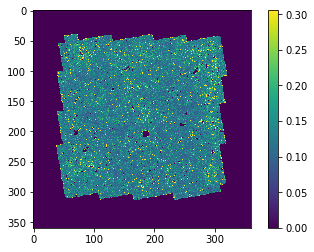

In [49]:
imshow(cov1)
colorbar()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

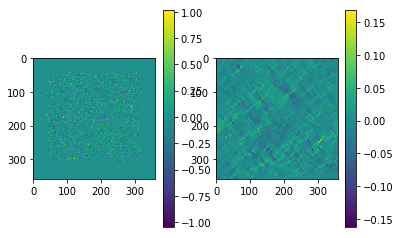

In [45]:
subplot(121)
imshow(noise_1)
colorbar()

subplot(122)
imshow(e2_sim)
colorbar()
denominator

Text(0.5,1,'$e_2 + n_c$')

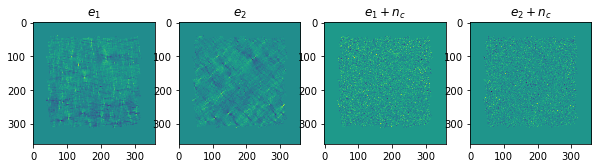

In [40]:
figure(figsize=[10,4])
subplot(141)
imshow(mask*e1_sim)
title(r'$e_1$')
subplot(142)
imshow(mask*e2_sim)
title(r'$e_2$')
subplot(143)
imshow(mask*(e1_sim + noise_1))
title(r'$e_1 + n_c$')
subplot(144)
imshow(mask*(e2_sim + noise_2))
title(r'$e_2 + n_c$')

#np.save('../data/ktng/cosmos_noise/e1_gal.npy', e1_sim + noise_1)
#np.save('../data/ktng/cosmos_noise/e2_gal.npy', e2_sim + noise_2)

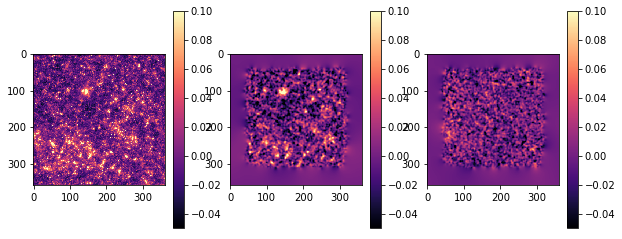

In [41]:
kappaE, kappaB = ks93(mask*(e1_sim + noise_1), mask*(e2_sim + noise_2))


figure(figsize=[10,4])

subplot(131)
imshow(kp[:,::-1], **kwargs);colorbar()
subplot(132)
imshow(gaussian_filter(kappaE,2)[:,::-1], **kwargs);colorbar()
subplot(133)
imshow(gaussian_filter(kappaB,2)[:,::-1], **kwargs);colorbar()